In [56]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

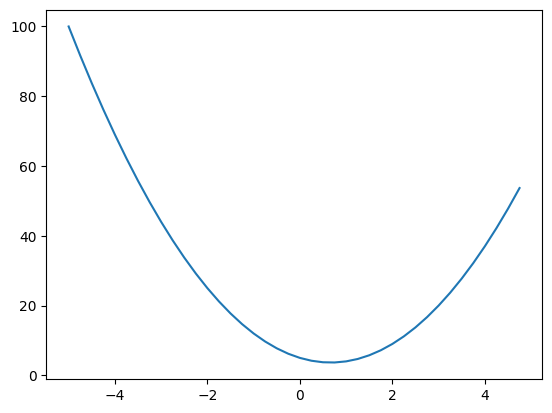

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.0000001
x = 3.0
(f(x+h)-f(x))/h

14.000000305713911

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [103]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
      return self * other

    def __pow__(self, other):
      assert isinstance(other, (int, float))
      out = Value(self.data**other, (self, ), f"**{other}")
      def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward
      return out

    def __truediv__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      return self * (other ** -1)


    def tanh(self):
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      out = Value(t, (self, ), 'tanh')
      def _backward():
        self.grad += (1-t**2) * out.grad
      out._backward = _backward
      return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')
      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward
      return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [47]:
a = Value(4.0)
b = Value(2.0)

a - b

Value(data=2.0)

In [27]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in getattr(v, "_prev", []):
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if getattr(n, "_op", None):
            opid = uid + n._op
            dot.node(name=opid, label=n._op)
            dot.edge(opid, uid)

    for n1, n2 in edges:
        if getattr(n2, "_op", None):
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

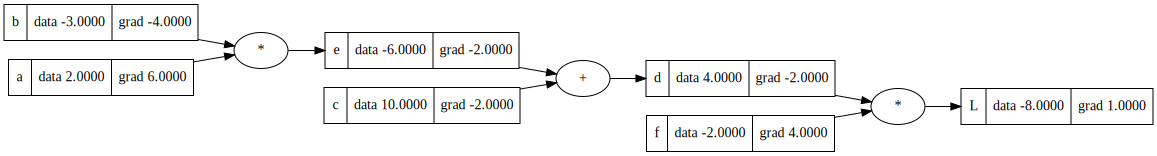

In [14]:
draw_dot(L)

In [13]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [15]:
def verify():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0 + h, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

verify()

3.9999999999995595


In [16]:
lr = 0.01

a.data += lr * a.grad
b.data += lr * b.grad
c.data += lr * c.grad
f.data += lr * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


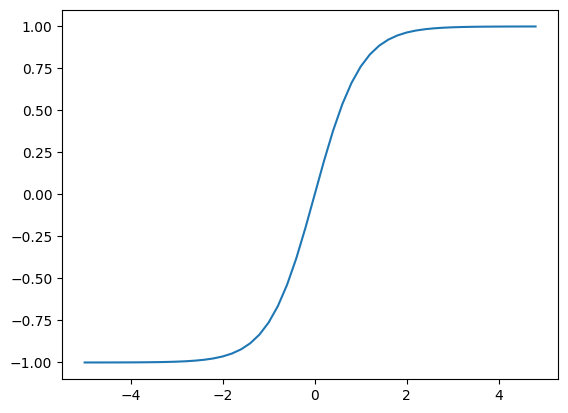

In [17]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid;

In [22]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

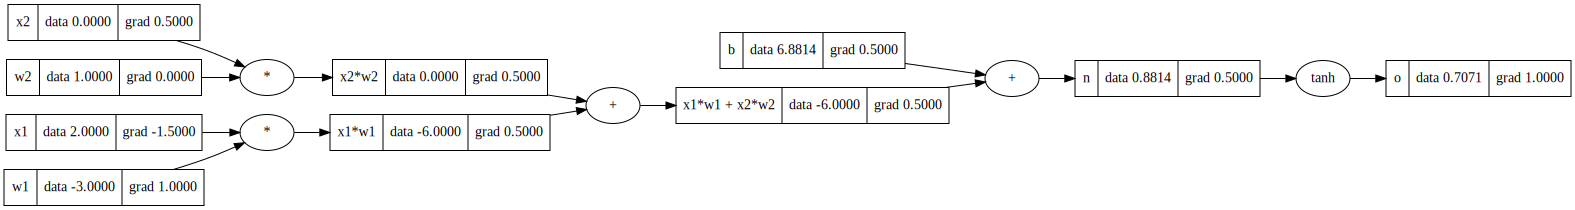

In [21]:
draw_dot(o)

In [20]:
o.grad = 1.0
n.grad = 1 - o.data**2
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

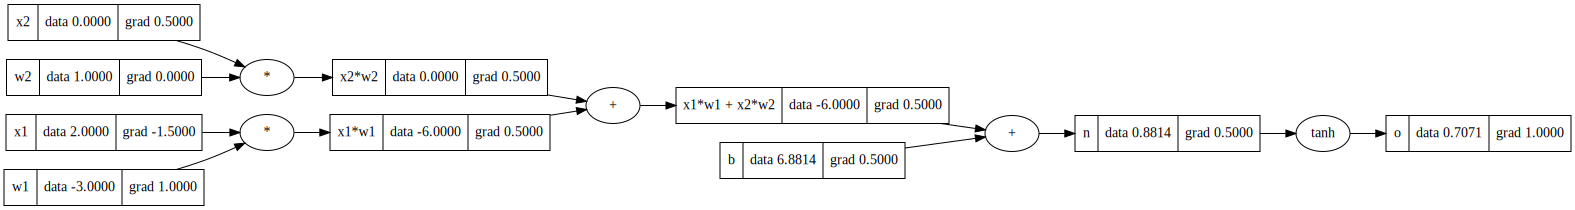

In [25]:
draw_dot(o)

In [24]:
o.backward()

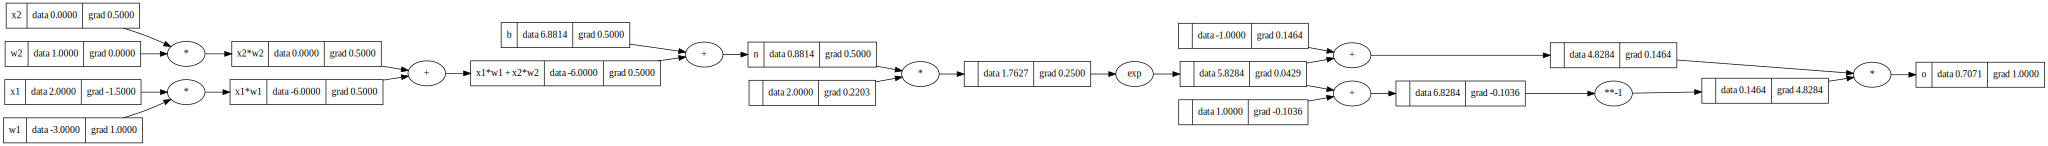

In [50]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp()

o = (e-1) / (e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [51]:
import torch

In [54]:
x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
x1 -1.5000003851533106
w2 0.0
w1 1.0000002567688737


In [112]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [113]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3825228984268595)

In [114]:
n.parameters()

[Value(data=-0.7129266680777253),
 Value(data=-0.3765860204626157),
 Value(data=-0.3107414763638574),
 Value(data=-0.6869581565354677),
 Value(data=0.2612385428061359),
 Value(data=0.9344263353536304),
 Value(data=0.697995237029891),
 Value(data=-0.40994908315206535),
 Value(data=0.9660407971090919),
 Value(data=-0.5434523911966198),
 Value(data=-0.9355898828005782),
 Value(data=0.3389340755209862),
 Value(data=-0.12596844961943532),
 Value(data=-0.21804700452466497),
 Value(data=-0.3181981367479525),
 Value(data=0.6632499839297439),
 Value(data=0.8841993338867924),
 Value(data=0.652903152014084),
 Value(data=0.8201843440168752),
 Value(data=0.0520227405763114),
 Value(data=-0.28186414994037245),
 Value(data=0.472643964274442),
 Value(data=-0.9936716191263888),
 Value(data=0.18462113101739308),
 Value(data=0.3333700326797884),
 Value(data=0.7023393508600941),
 Value(data=0.7079057350166809),
 Value(data=0.6340693698679429),
 Value(data=-0.5697551526375313),
 Value(data=-0.3585058421881

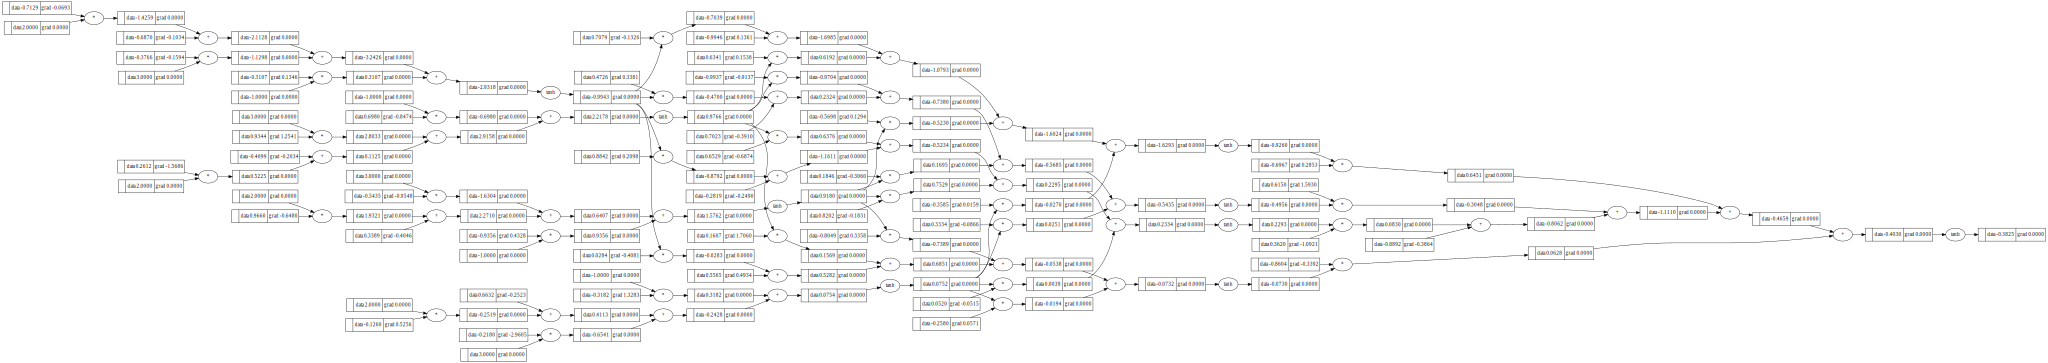

In [122]:
draw_dot(n(x))

In [116]:
n(x).backward()

In [117]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.3825228984268595),
 Value(data=0.33745881515751486),
 Value(data=-0.9434381619654704),
 Value(data=0.3043750109968395)]

In [118]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.187259013764639)

In [119]:
loss.backward()

In [120]:
n.layers[0].neurons[0].w[0].grad

-0.06926645509571093

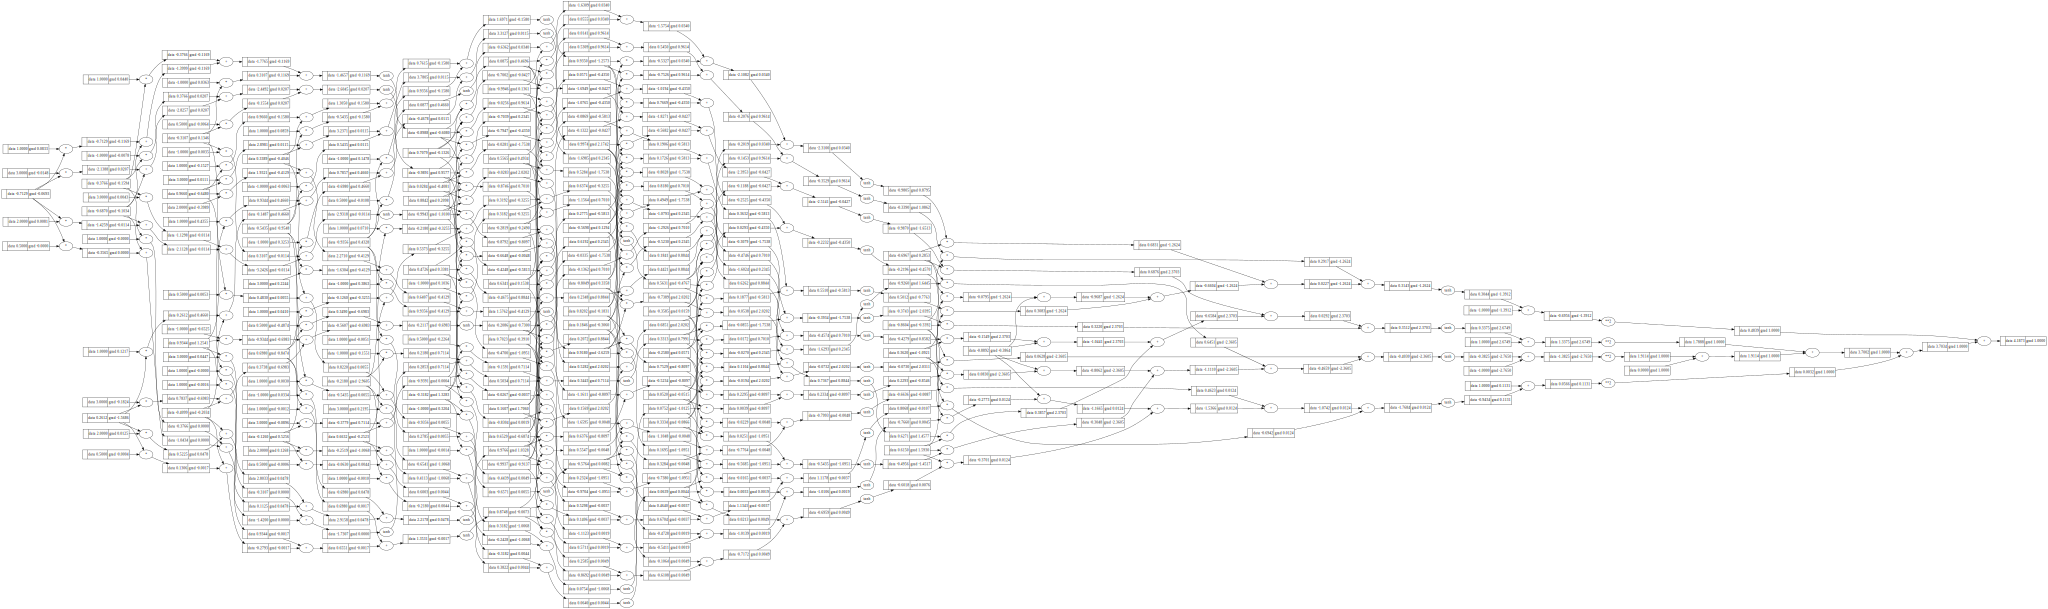

In [121]:
draw_dot(loss)

In [182]:
for k in range(10):
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 0.0002724564580113763
1 0.00027182809035708954
2 0.00027120302149023675
3 0.00027058122481620785
4 0.0002699626740287767
5 0.0002693473431061656
6 0.0002687352063072398
7 0.000268126238167641
8 0.0002675204134961069
9 0.00026691770737077375


In [183]:
ypred

[Value(data=0.9992225177730135),
 Value(data=-0.9963590660403245),
 Value(data=-0.9841069909963274),
 Value(data=0.99931509601552)]